## Testing the different models

- Naive Forecast
- SARIMA
- LSTM
- LSTM SeqToSeq
- XGBoost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from river_forecast.training_data_access import get_combined_flow_split

In [4]:
train, validation, test = get_combined_flow_split()

Text(0, 0.5, 'Flow')

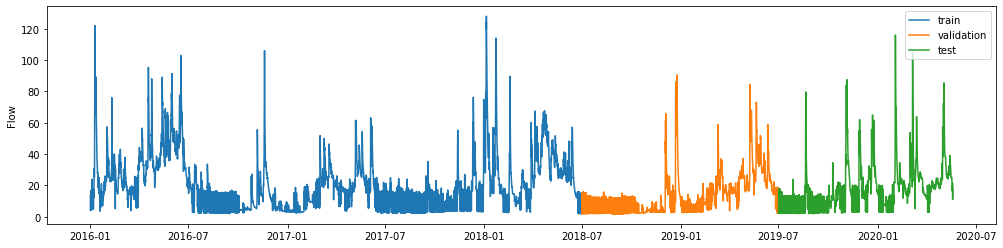

In [5]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.plot(train, label='train')
ax.plot(validation, label='validation')
ax.plot(test, label='test')
ax.legend()
ax.set_ylabel('Flow')

In [6]:
from river_forecast.forecast import SARIMAXForecast, NaiveForecast, LSTMForecast, LSTMSeq2SeqForecast, XGBForecast

In [7]:
models = {
    "Naive" : NaiveForecast(),
    "SARIMA": SARIMAXForecast(),
    "LSTM": LSTMForecast(),
    "LSTMSeq2Seq": LSTMSeq2SeqForecast(),
    "XGBoost": XGBForecast()}

[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

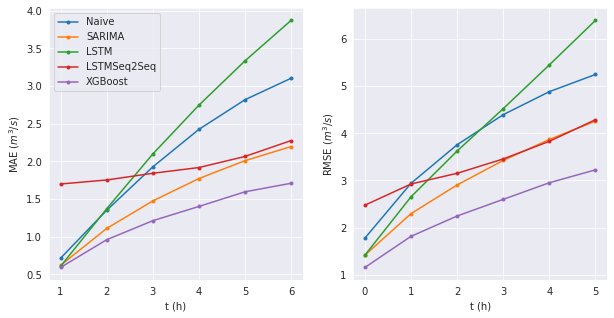

In [31]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2,figsize=(10, 5))

for name, model in models.items():
    
    errors = model.get_error_metrics()
    
    ax = axs[0]
    ax.plot(np.arange(1, 7), errors['mae'], '.-', label=name)
    ax.set_xlabel('t (h)')
    ax.set_ylabel('MAE ($m^3/s$)')
    
    ax = axs[1]
    ax.plot(errors['rmse'], '.-', label=name)
    ax.set_xlabel('t (h)')
    ax.set_ylabel('RMSE ($m^3/s$)')
    
axs[0].legend()
    

## Alternative error comparison and prediction examples

In [10]:
input_length = 72
forecast_length = int(6)
n_possible_forecasts = len(validation) - input_length + 1 - forecast_length
n_forecasts = 20 # n_possible_forecasts


In [11]:
# Put this part in a module 

forecasts = np.zeros((5, n_forecasts, forecast_length))
real_values = np.zeros((n_forecasts, forecast_length))
real_recent_flows = np.zeros((n_forecasts, 12))
np.random.seed(5)
for i, j in enumerate(np.random.choice(n_possible_forecasts, size=n_forecasts, replace=False)):
    if i%50 == 0:
        print(i, 'out of', n_possible_forecasts)
    recent_flow = validation.iloc[j:(j + input_length)]
    real_recent_flows[i, :] = recent_flow.iloc[-12:]['discharge']
    real_values[i, :] = validation.iloc[(j + input_length):(j + input_length + forecast_length)]['discharge']
    forecasts[4, i, :] = bst.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[3, i, :] = lstm2.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[2, i, :] = lstm.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[1, i, :] = sf.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[0, i, :] = nf.dynamic_forecast(recent_flow, n_hours=forecast_length)

0 out of 8682


In [8]:
maes = np.mean(np.abs(forecasts - real_values[np.newaxis, ...]), axis=1)

NameError: name 'forecasts' is not defined

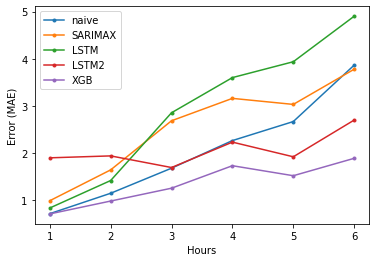

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, maes[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, maes[3], marker='.', label='LSTM2')
ax.plot(np.arange(forecast_length) + 1, maes[4], marker='.', label='XGB')

ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
ax.legend()

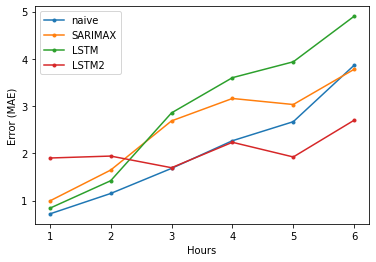

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, maes[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, maes[3], marker='.', label='LSTM2')

ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
# ax.set_xlim([0.9, 6.1])
# ax.set_ylim([0, 3.5])
ax.legend()

In [15]:
rmses = np.sqrt(np.mean((forecasts - real_values[np.newaxis, ...])**2, axis=1))

Text(0.5, 0, 'Hours')

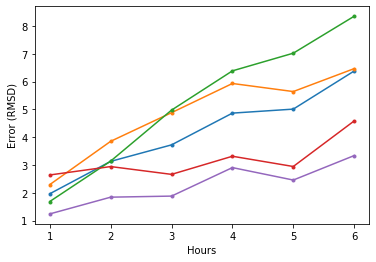

In [16]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, rmses[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, rmses[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, rmses[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, rmses[3], marker='.', label='LSTM2')
ax.plot(np.arange(forecast_length) + 1, rmses[4], marker='.', label='XGB')
ax.set_ylabel('Error (RMSD)')
ax.set_xlabel('Hours')

#### Plotting example curves

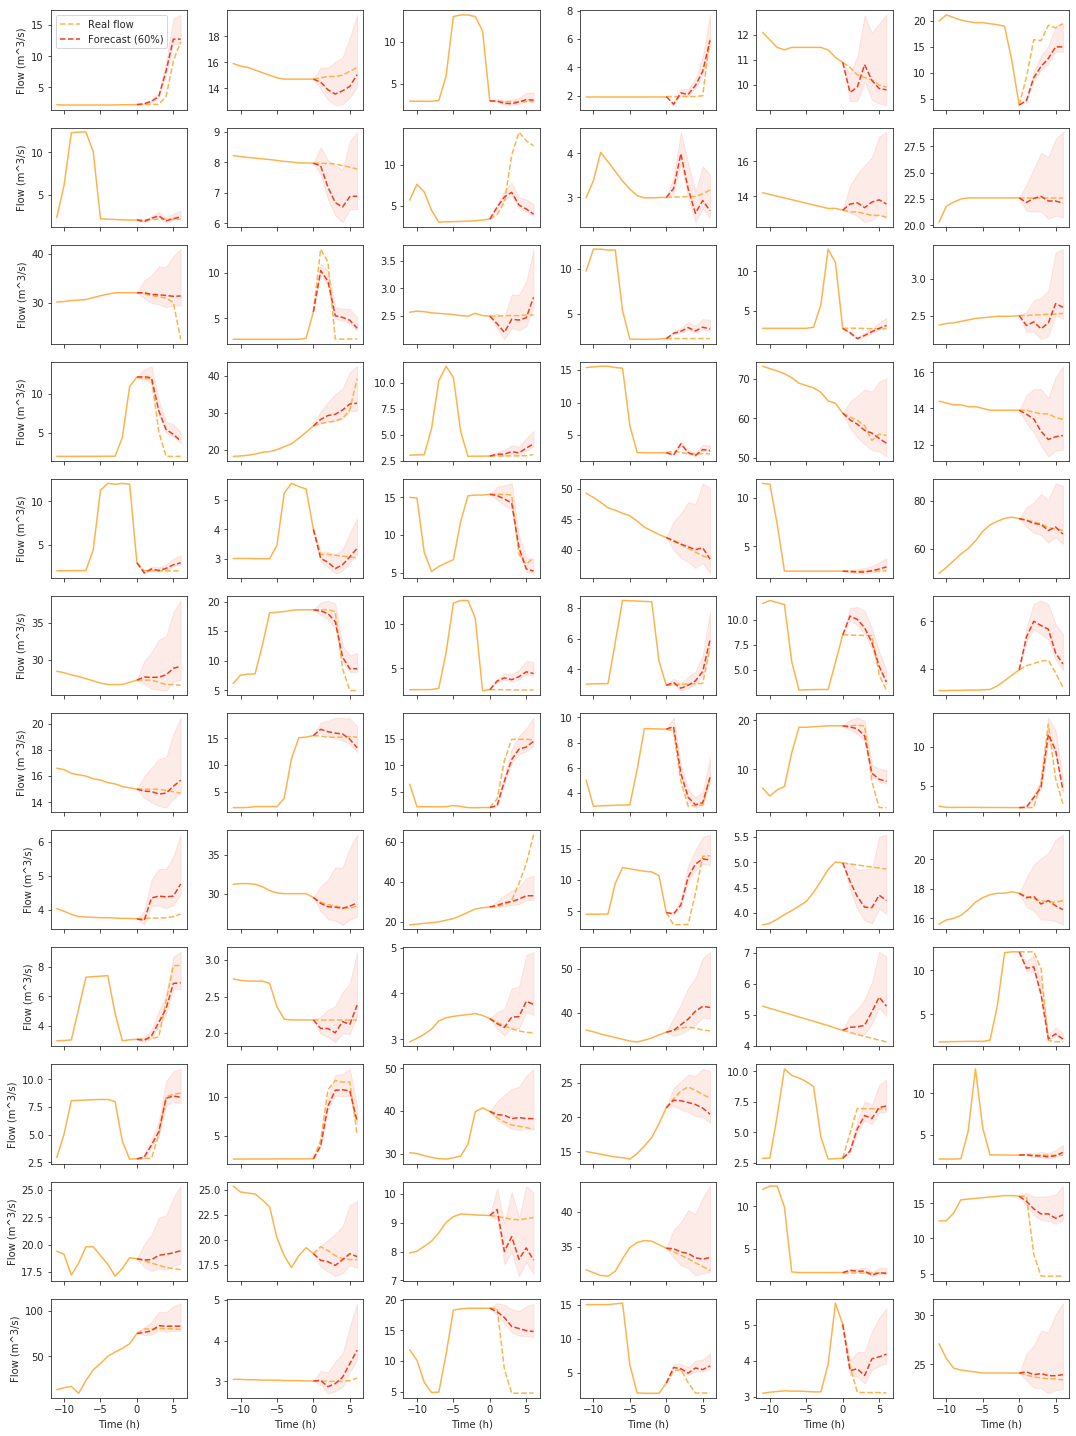

In [134]:
sns.set_style('ticks')

errors = forecasts[4, :, :] / real_values[:, :]

negative_ci = np.insert(np.percentile(errors, 20, axis=0), 0, 1)
positive_ci = np.insert(np.percentile(errors, 80, axis=0), 0, 1)

fig, axs = plt.subplots(12, 6, figsize=(15, 20), sharex=True)
colors = ['#feb24c','#f03b20']
for i, ax in enumerate(axs.flatten()):
    last_value = real_recent_flows[i, -1]
    ax.plot(np.arange(-11, 1), real_recent_flows[i, :], color=colors[0])
    ax.plot(np.arange(0, 7), np.insert(real_values[i, :], 0, last_value), color=colors[0], linestyle='--', label='Real flow')
    
    pred = np.insert(forecasts[4, i, :], 0, last_value)
    ax.plot(np.arange(0, 7), pred, color=colors[1], linestyle='--', label='Forecast (60%)')

    ax.fill_between(np.arange(0, 7), pred * negative_ci , pred * positive_ci, color=colors[1],
                   alpha=0.1)
    
for ax in axs[-1, :]:
    ax.set_xlabel('Time (h)')
for ax in axs[:, 0]:
    ax.set_ylabel('Flow (m^3/s)')
axs[0, 0].legend()
plt.tight_layout()